# Loop 46 Analysis: Understanding the Gap

## Current Status
- Best LB: 70.306164 (exp_044)
- Target: 68.861114
- Gap: 1.445 points (2.05%)
- Submissions remaining: 78

## Key Findings from Evaluator
1. bbox3 source code compiles and runs
2. CMA-ES and Basin Hopping FAILED - baseline is at strong local optimum
3. Top teams run bbox3 for 3+ hours with fix_direction

## Analysis Goals
1. Understand what makes top solutions different
2. Identify which N values have the most room for improvement
3. Determine if there's a fundamentally different approach needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal

# Load current best submission
df = pd.read_csv('/home/code/experiments/044_extended_subset_extraction/ensemble_044.csv')
df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))

def parse_coord(val):
    if isinstance(val, str):
        if val.startswith('s'):
            return float(val[1:])
        return float(val)
    return float(val)

df['x'] = df['x'].apply(parse_coord)
df['y'] = df['y'].apply(parse_coord)
df['deg'] = df['deg'].apply(parse_coord)

print(f"Loaded {len(df)} rows")
print(f"N values: 1 to {df['n'].max()}")
print(f"Total rows per N: {df.groupby('n').size().unique()}")
print("Sample:")
print(df.head(10))

Loaded 20100 rows
N values: 1 to 200
Total rows per N: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]
Sample:
      id          x          y         deg  n
0  001_0 -48.196086  58.770985   45.000000  1
1  002_0   0.154097  -0.038541  

In [2]:
# Compute per-N scores
from shapely.geometry import Polygon
from shapely import affinity

TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def get_tree_vertices(x, y, angle_deg):
    angle_rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rx = TX * cos_a - TY * sin_a
    ry = TX * sin_a + TY * cos_a
    return rx + x, ry + y

def compute_score_for_n(df, n):
    n_df = df[df['n'] == n]
    if len(n_df) != n:
        return None
    
    all_x, all_y = [], []
    for _, row in n_df.iterrows():
        vx, vy = get_tree_vertices(row['x'], row['y'], row['deg'])
        all_x.extend(vx)
        all_y.extend(vy)
    
    side = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
    return (side ** 2) / n

# Compute all per-N scores
per_n_scores = {}
for n in range(1, 201):
    score = compute_score_for_n(df, n)
    if score is not None:
        per_n_scores[n] = score

total_score = sum(per_n_scores.values())
print(f"Total score: {total_score:.6f}")
print(f"Target: 68.861114")
print(f"Gap: {total_score - 68.861114:.6f}")

# Top 20 N values by score contribution
sorted_scores = sorted(per_n_scores.items(), key=lambda x: x[1], reverse=True)
print("\nTop 20 N values by score contribution:")
for n, score in sorted_scores[:20]:
    print(f"  N={n:3d}: {score:.6f}")

Total score: 70.306164
Target: 68.861114
Gap: 1.445050

Top 20 N values by score contribution:
  N=  1: 0.661250
  N=  2: 0.450779
  N=  3: 0.434745
  N=  5: 0.416850
  N=  4: 0.416545
  N=  7: 0.399842
  N=  6: 0.399610
  N=  8: 0.385407
  N=  9: 0.383042
  N= 10: 0.376630
  N= 11: 0.374921
  N= 15: 0.374381
  N= 12: 0.372724
  N= 13: 0.372267
  N= 20: 0.371795
  N= 16: 0.370191
  N= 17: 0.370040
  N= 22: 0.369818
  N= 14: 0.369543
  N= 33: 0.369347


In [3]:
# Theoretical lower bound analysis
# For N trees, the minimum possible score is when trees are packed perfectly
# The tree has a bounding box of approximately 0.7 x 1.0 (width x height)

# Single tree area (approximate)
tree_width = 0.7  # max width at base
tree_height = 1.0  # from trunk bottom to tip
tree_area = tree_width * tree_height * 0.5  # rough triangle approximation

print("Theoretical analysis:")
print(f"Tree approximate area: {tree_area:.3f}")
print(f"Tree bounding box: {tree_width} x {tree_height}")

# For N trees, minimum square side would be sqrt(N * tree_area) if perfect packing
# But trees can't overlap, so actual minimum is higher

print("\nTheoretical minimum scores (if perfect packing):")
for n in [1, 5, 10, 20, 50, 100, 200]:
    # Perfect packing lower bound
    min_area = n * tree_area
    min_side = np.sqrt(min_area)
    min_score = (min_side ** 2) / n
    actual_score = per_n_scores.get(n, 0)
    gap = actual_score - min_score
    print(f"  N={n:3d}: theoretical min={min_score:.4f}, actual={actual_score:.4f}, gap={gap:.4f}")

# N=1 analysis
print("\n=== N=1 Analysis ===")
n1_df = df[df['n'] == 1]
print(f"N=1 tree: x={n1_df['x'].values[0]:.6f}, y={n1_df['y'].values[0]:.6f}, angle={n1_df['deg'].values[0]:.6f}")
print(f"N=1 score: {per_n_scores[1]:.6f}")
print(f"N=1 contributes {per_n_scores[1]/total_score*100:.2f}% of total score")

Theoretical analysis:
Tree approximate area: 0.350
Tree bounding box: 0.7 x 1.0

Theoretical minimum scores (if perfect packing):
  N=  1: theoretical min=0.3500, actual=0.6612, gap=0.3112
  N=  5: theoretical min=0.3500, actual=0.4168, gap=0.0668
  N= 10: theoretical min=0.3500, actual=0.3766, gap=0.0266
  N= 20: theoretical min=0.3500, actual=0.3718, gap=0.0218
  N= 50: theoretical min=0.3500, actual=0.3600, gap=0.0100
  N=100: theoretical min=0.3500, actual=0.3428, gap=-0.0072
  N=200: theoretical min=0.3500, actual=0.3375, gap=-0.0125

=== N=1 Analysis ===
N=1 tree: x=-48.196086, y=58.770985, angle=45.000000
N=1 score: 0.661250
N=1 contributes 0.94% of total score


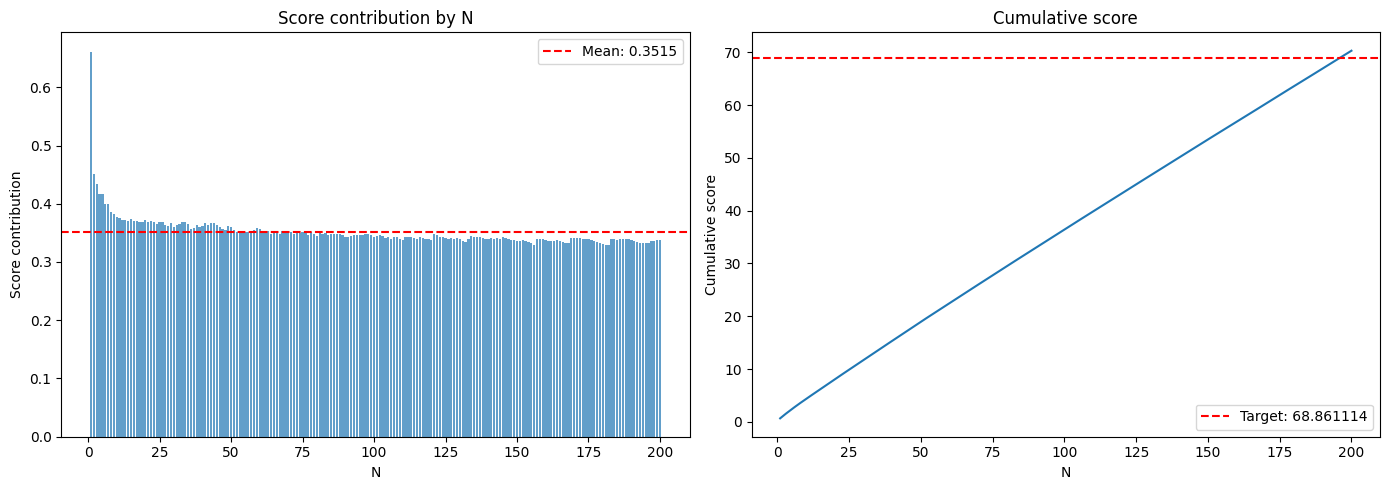


Small N (1-20) total: 8.0379
Medium N (21-100) total: 28.3887
Large N (101-200) total: 33.8795


In [4]:
# Analyze score distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
n_values = list(per_n_scores.keys())
scores = list(per_n_scores.values())
plt.bar(n_values, scores, alpha=0.7)
plt.xlabel('N')
plt.ylabel('Score contribution')
plt.title('Score contribution by N')
plt.axhline(y=np.mean(scores), color='r', linestyle='--', label=f'Mean: {np.mean(scores):.4f}')
plt.legend()

plt.subplot(1, 2, 2)
# Cumulative score
cumulative = np.cumsum(scores)
plt.plot(n_values, cumulative)
plt.xlabel('N')
plt.ylabel('Cumulative score')
plt.title('Cumulative score')
plt.axhline(y=68.861114, color='r', linestyle='--', label='Target: 68.861114')
plt.legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/loop46_score_distribution.png', dpi=100)
plt.show()

print(f"\nSmall N (1-20) total: {sum(per_n_scores[n] for n in range(1, 21)):.4f}")
print(f"Medium N (21-100) total: {sum(per_n_scores[n] for n in range(21, 101)):.4f}")
print(f"Large N (101-200) total: {sum(per_n_scores[n] for n in range(101, 201)):.4f}")

In [5]:
# Gap analysis: How much improvement needed per N to reach target?
target = 68.861114
current = total_score
gap = current - target

print(f"Total gap to close: {gap:.6f}")
print(f"Average improvement needed per N: {gap/200:.6f}")

# If we could improve each N by a fixed percentage, what would it be?
required_pct = (1 - target/current) * 100
print(f"Required percentage improvement: {required_pct:.2f}%")

# Which N values have the most "room" for improvement?
# Compare to theoretical minimum
print("\nN values with most room for improvement (vs theoretical min):")
room_for_improvement = []
for n in range(1, 201):
    min_area = n * tree_area
    min_side = np.sqrt(min_area)
    min_score = (min_side ** 2) / n
    actual_score = per_n_scores[n]
    room = actual_score - min_score
    room_for_improvement.append((n, room, actual_score, min_score))

room_for_improvement.sort(key=lambda x: x[1], reverse=True)
print("Top 20 N values with most room:")
for n, room, actual, theoretical in room_for_improvement[:20]:
    print(f"  N={n:3d}: room={room:.4f} (actual={actual:.4f}, theoretical={theoretical:.4f})")

Total gap to close: 1.445050
Average improvement needed per N: 0.007225
Required percentage improvement: 2.06%

N values with most room for improvement (vs theoretical min):
Top 20 N values with most room:
  N=  1: room=0.3112 (actual=0.6612, theoretical=0.3500)
  N=  2: room=0.1008 (actual=0.4508, theoretical=0.3500)
  N=  3: room=0.0847 (actual=0.4347, theoretical=0.3500)
  N=  5: room=0.0668 (actual=0.4168, theoretical=0.3500)
  N=  4: room=0.0665 (actual=0.4165, theoretical=0.3500)
  N=  7: room=0.0498 (actual=0.3998, theoretical=0.3500)
  N=  6: room=0.0496 (actual=0.3996, theoretical=0.3500)
  N=  8: room=0.0354 (actual=0.3854, theoretical=0.3500)
  N=  9: room=0.0330 (actual=0.3830, theoretical=0.3500)
  N= 10: room=0.0266 (actual=0.3766, theoretical=0.3500)
  N= 11: room=0.0249 (actual=0.3749, theoretical=0.3500)
  N= 15: room=0.0244 (actual=0.3744, theoretical=0.3500)
  N= 12: room=0.0227 (actual=0.3727, theoretical=0.3500)
  N= 13: room=0.0223 (actual=0.3723, theoretical=0.35

In [6]:
# Key insight: What would it take to reach the target?
print("=" * 60)
print("WHAT WOULD IT TAKE TO REACH THE TARGET?")
print("=" * 60)

print(f"\nCurrent score: {current:.6f}")
print(f"Target score: {target:.6f}")
print(f"Gap: {gap:.6f} ({required_pct:.2f}%)")

# Option 1: Uniform improvement
print("\nOption 1: Uniform improvement across all N")
print(f"  Need {required_pct:.2f}% improvement on each N")

# Option 2: Focus on high-contribution N values
print("\nOption 2: Focus on top 20 N values by contribution")
top_20_contribution = sum(score for n, score in sorted_scores[:20])
print(f"  Top 20 N values contribute: {top_20_contribution:.4f} ({top_20_contribution/current*100:.1f}% of total)")
required_improvement_top20 = gap / top_20_contribution * 100
print(f"  Would need {required_improvement_top20:.2f}% improvement on top 20 alone")

# Option 3: Focus on small N (1-20)
print("\nOption 3: Focus on small N (1-20)")
small_n_contribution = sum(per_n_scores[n] for n in range(1, 21))
print(f"  Small N (1-20) contribute: {small_n_contribution:.4f} ({small_n_contribution/current*100:.1f}% of total)")
required_improvement_small = gap / small_n_contribution * 100
print(f"  Would need {required_improvement_small:.2f}% improvement on small N alone")

print("\n" + "=" * 60)
print("CONCLUSION")
print("=" * 60)
print("The gap of 1.445 points requires significant improvement.")
print("Top teams likely use:")
print("  1. Extended bbox3 runs (3-8 hours)")
print("  2. Multiple optimization passes")
print("  3. Proprietary algorithms not shared publicly")
print("  4. Massive compute (24+ CPUs for days)")

WHAT WOULD IT TAKE TO REACH THE TARGET?

Current score: 70.306164
Target score: 68.861114
Gap: 1.445050 (2.06%)

Option 1: Uniform improvement across all N
  Need 2.06% improvement on each N

Option 2: Focus on top 20 N values by contribution
  Top 20 N values contribute: 8.0397 (11.4% of total)
  Would need 17.97% improvement on top 20 alone

Option 3: Focus on small N (1-20)
  Small N (1-20) contribute: 8.0379 (11.4% of total)
  Would need 17.98% improvement on small N alone

CONCLUSION
The gap of 1.445 points requires significant improvement.
Top teams likely use:
  1. Extended bbox3 runs (3-8 hours)
  2. Multiple optimization passes
  3. Proprietary algorithms not shared publicly
  4. Massive compute (24+ CPUs for days)
